In [1]:
### Required Libraries
import os, csv
import re
import math
import time
import numpy as np
import pandas as pd
from pathlib import Path
import datetime as dt
from matplotlib import pyplot as plt
#Preprocessig
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans, silhouette_score, KShape
from sktime.clustering.k_medoids import TimeSeriesKMedoids
from sktime.clustering.k_means import TimeSeriesKMeans as TSKMeans
from sktime.clustering.k_shapes import TimeSeriesKShapes

In [2]:
### Preset plot params
plt.rcParams['figure.figsize'] = (26,14)
plt.style.use('fivethirtyeight')
y_ticks = np.arange(0,101,10)

In [3]:
### 0.) Presets - Checking, if there are directories to work with. If there no directories then create one
cwd = os.getcwd()

# Check exisiting working directory, if not create one
if not os.path.exists(cwd + "/" + "working_dir"):
    os.makedirs("working_dir")
    print("Working directory successfully created")
    
    if not os.path.exists(cwd + "/" + "working_dir" + "/" + "done"):
        os.makedirs(cwd + "/" + "working_dir" + "/" + "done")
        print("Done directory successfully created")
    else:
        print("Done directory already exists")
    
    if not os.path.exists(cwd + "/" + "working_dir" + "/" + "raw_data"):
        os.makedirs(cwd + "/" + "working_dir" + "/" + "raw_data")
    else:
        print("Raw data directory already exists")
else:
    print("Working directory already exists, but check existing done and raw directory!")
    
    if not os.path.exists(cwd + "/" + "working_dir" + "/" + "done"):
        os.makedirs(cwd + "/" + "working_dir" + "/" + "done")
        print("Done directory successfully created")
    else:
        print("Done directory already exists")
        
    if not os.path.exists(cwd + "/" + "working_dir" + "/" + "raw_data"):
        os.makedirs(cwd + "/" + "working_dir" + "/" + "raw_data")
        print("Raw data directory successfully created")
    else:
        print("Raw data directory already exists")

Working directory already exists, but check existing done and raw directory!
Done directory already exists
Raw data directory already exists


In [4]:
### 1.) Data Preprocessing

#################################################################################################

# Define path variable
# First path variable contains raw data   -  Annotation: Cluster all available data -> move all out data crop folder into raw_data folder; per default only the data from the residuals folder are used
WORK_PATH = Path(cwd + "/" + "working_dir" + "/" + "raw_data")
DONE_PATH = Path(cwd + "/" + "working_dir" + "/" + "done")

# List all files within working directory and its sub-directories
tmp_list = []
tmp_part = []        # Total time series (length in total) = 900 = (12*60 ) + (15*12)
df_list = []         # 900 Data frames -> each data frames represent one year; length of each Data frames (or time series) are 365

#filename_only = []

for root, dirs, files in sorted(os.walk(WORK_PATH)):
    for file in files:
        if file.endswith(".txt"):
            tmp_list.append(os.path.join(root, file))
            
# Clear file list, which contains log files like checkpoint in name
regex = re.compile(r'-checkpoint.txt')
file_list = [i for i in tmp_list if not regex.search(i)]

# Process raw data files and convert them to a manageable data format, like csv
# At first check if the list of files is empty, if not then continue else skip because no files exists to work with
if file_list:
    for i, elem in enumerate(file_list):
        raw_files = pd.read_csv(file_list[i], sep="\s+", header=3, usecols=[0,1,6])  #1 Read all files, but only Jahr, Tag and BOF (%nFK)

        #2 Alternativ to slicing data (filtering) -> Remove meta information 
        df_file = raw_files.loc[raw_files["Jahr"] != "Station:", "Jahr":"BOF"]
        df_file = raw_files.loc[raw_files["Jahr"] != "Flexibilisierung:", "Jahr":"BOF"]
        df_file = raw_files.loc[raw_files["Jahr"] != "Hauptfrucht:", "Jahr":"BOF"]
        # Special treatment for Jahr, Tag and BOF
        df_file = raw_files.loc[raw_files["Jahr"].str.contains("Jahr|mm") == False, "Jahr":"BOF"]
        
        #3 After removing superfluous information reset index to align them 
        df_file.dropna(inplace=True)
        df_file.reset_index(drop=True, inplace=True)

        #4 Rename columns caption via index
        df_file = df_file.rename(columns={df_file.columns[2]: "BOF (%nFK)"})

        #5 Check the number of days of a year, if the year contains more than 365 days then remove the day 366 -> harmonise data length
        indexNames = df_file.loc[df_file["Tag"] == "366", "Jahr":"BOF (%nFK)"].index
        df_file = df_file.drop(indexNames)

        #6 dtype conversion, because per default all read data are of type object (or string)
        # Use int32/float32 instead of int64/float64 by default to save memory
        df_file['Jahr'] = df_file['Jahr'].astype('int32')
        df_file['Tag'] = df_file['Tag'].astype('int32')
        # Special treatment for the col "BOF (%nFK)" which objects are comma separation instead dot 
        # => relevant for conversion
        df_file['BOF (%nFK)'] = df_file['BOF (%nFK)'].apply(lambda x: x.replace(',', '.')).astype('float32')

        #7 Combine cols "Jahr" and "Tag" and then convert it to datetime format, ... 
        # ... whereby Day 1, 2019 can be translated to jan 1st 2019
        # a.) Create a new col 'Date'
        df_file['Date'] = df_file['Jahr'] * 1000 + df_file['Tag']
        
        # b.) Convert current date format YYYY-DD to actual date format YYYY-MM-DD
        df_file['Date'] = pd.to_datetime(df_file['Date'], format='%Y%j')
        
        #8 insert column using insert(position, column_name, first_column) function              
        df_file.insert(0, 'Date', df_file.pop('Date'))

        #9 Omit superfluous columns
        df_file = df_file.drop(columns=["Jahr", "Tag"])
        
        #10 Set Date as (time) index
        df_file.set_index('Date', inplace=True)
        df_file.sort_index(inplace=True)
        
        #11 Partition dataframe by years -> Required to treat cluster daily based data for a year as data point (thus clustering whole year)
        for j in df_file.groupby(pd.DatetimeIndex(df_file.index).year):
            tmp_part.append(j)
        
        #Filenames without extension .txt
        #base = os.path.basename(file_list[i])
        #tmp = os.path.splitext(base)
        #filename_only.append(tmp[0])
        
        #export_csv = df_file.to_csv(str(DONE_PATH) + "/" + filename_only[i] + ".csv", sep=";", index=False, header=True, encoding="utf-8")
else:
    print("List is empty, hence no files in directory to process")
    

#12  Get dataframe from the tuple -> extract from partition only the data frames, e.g. [(1961, dataframe)]
for k, df in enumerate(tmp_part):
    df_list.append(df[1])
    

#################################################################################################

In [5]:
### 2.) Convert each time series from pd.dataframe from to pd.series
df_list_series = []

for i, series in enumerate(df_list):
    df_tmp = df_list[i].squeeze()
    df_list_series.append(df_tmp)

In [6]:
### 3.) Create label 'year'
year_tmp = []

for i, elem in enumerate(tmp_part):
    year_tmp.append(elem[0])

df_data = pd.DataFrame({"Jahr": year_tmp, "Series": df_list_series})

In [ ]:
# Export to a portable format
#export_hdf = df_data.to_hdf("data.h5", key="df_data", mode="w")

In [7]:
### 4.) Quick test, if all series are equal in length (= 365 days)
for i, elem in enumerate(df_list):
    if len(df_list[i]) == 365:
        pass
    else:
        print("Warning! There are potential series that are not equal in length!")

In [8]:
### 5.) Presets for clustering

# Quick normalize time series data -> [0,1]
scaler = MinMaxScaler()

df_list_norm = []

for n, foo in enumerate(df_list):
    tmp = scaler.fit_transform(df_list[n])
    
    df_list_norm.append(tmp)

# Reshape required for clustering 
for m, fool in enumerate(df_list_norm):
    df_list_norm[m] = df_list_norm[m].reshape(len(df_list_norm[m]))
    
    
# del n, foo, m, fool, tmp

In [9]:
### 6.) Clustering data - Presetting
seed = 22
k_cluster = 100

In [ ]:
# A.) K-Means with dtw - Not useful, because run time is too high and thus not feasible. Also the results are not better than the euclidean distance
start_time = time.time()

km_dtw = TimeSeriesKMeans(n_clusters=k_cluster, metric="softdtw", max_iter_barycenter=1000, random_state=seed, n_init=10, n_jobs=-1)
label_dtw = km_dtw.fit_predict(df_list_norm)

end_time = time.time()

In [10]:
### 7.) Clustering with K-Means

# B.) K-Means with euclidean from tslearn - Apply this K-Means for plotting 
# -> There are issues with plotting the cluster results with sktime (cut off cluster although cluster labels are present -> 100 cluster, but only 69 are visually displayed)
start_time = time.time()

km_euc = TimeSeriesKMeans(n_clusters=k_cluster, metric="euclidean", max_iter=1000, n_init=50, random_state=seed, n_jobs=-1)
label_euc = km_euc.fit_predict(df_list_norm)

end_time = time.time()

In [ ]:
# Convert List to np.array
df_norm = np.array(df_list_norm)

In [ ]:
# C.) K-Medoids with euclidean from sktime Lib 
start_time = time.time()

k_medoids = TimeSeriesKMedoids(n_clusters=k_cluster, metric="euclidean", n_init=30, max_iter=1000, random_state=seed)
label_medoids = k_medoids.fit_predict(df_norm)

end_time = time.time()

In [ ]:
# D.) K-Means with euclidean from sktime Lib - Apply this K-Means for comparison with K-Medoids
start_time = time.time()

k_means = TSKMeans(n_clusters=k_cluster, metric="euclidean", max_iter=1000, n_init=30, random_state=seed)
label_kmeans = k_means.fit_predict(df_norm)

end_time = time.time()

In [ ]:
df_reshaped = np.reshape(df_list_norm,(900, 365, 1))

In [ ]:
### Optional: Validation clustering result

print('Silhoutte Score(n_cluster=100):', silhouette_score(df_norm, labels=label_kmeans, metric="euclidean"))
print('Silhoutte Score(n_cluster=100):', silhouette_score(df_reshaped, labels=label_euc, metric="euclidean"))
print('Silhoutte Score(n_cluster=100):', silhouette_score(df_norm, labels=label_medoids, metric="euclidean"))

In [12]:
### 8.) Assign labels to data
df_data.insert(loc=2, column="Labels", value=km_euc.labels_)

In [ ]:
#df_data.set_index(['Jahr'], inplace=True)
#df_data.reset_index(level=1, inplace=True)

In [ ]:
### 9:) Export to a portable format hdf5
export_hdf = df_data.to_hdf("data.h5", key="df_data", mode="w")
export_data = df_data.to_csv('labeled_data_kmeans.csv', sep=";", index=False, header=True, encoding="utf-8")

[12  6 12 18 19  9 14 18  6  7  9 15 12  6 12  6 12  6 15 12  9 12  6 12
 10 12 17  9  9  6 12  6  9  6 12 12  9  9  6 12  6 10  6 11 12 15  9  6
  6  9  6 12  6 14  6  9 12  6  9 12 18  6  3  6  6 14  6  6  9  6  6  6
  6  6  6  6  6  6  6  6  6  9  6  6  9 18  6  6 12  6  6  3  6  6  9 12
  6 10  6  9]


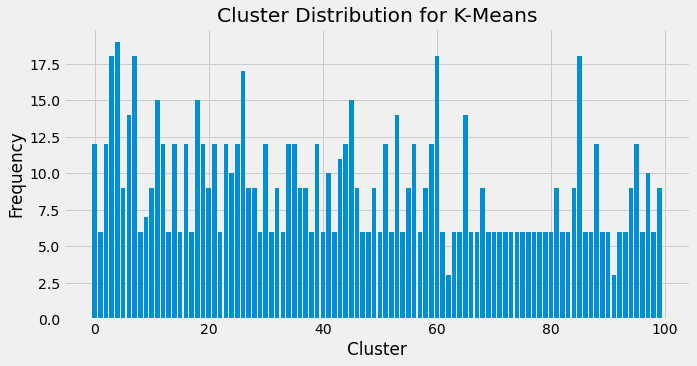

In [13]:
### Optional: Count data objects for each label K-Means -> Shows distribution
df_count = df_data.groupby(["Labels"])["Labels"].count()

print(df_count.values)

plt.figure(figsize=(10,5))
plt.title("Cluster Distribution for K-Means")
plt.bar(df_count.index, df_count.values)
plt.ylabel("Frequency")
plt.xlabel("Cluster")
plt.show()

In [ ]:
tmp_reshape = np.reshape(tmp_data, (20620, 365))

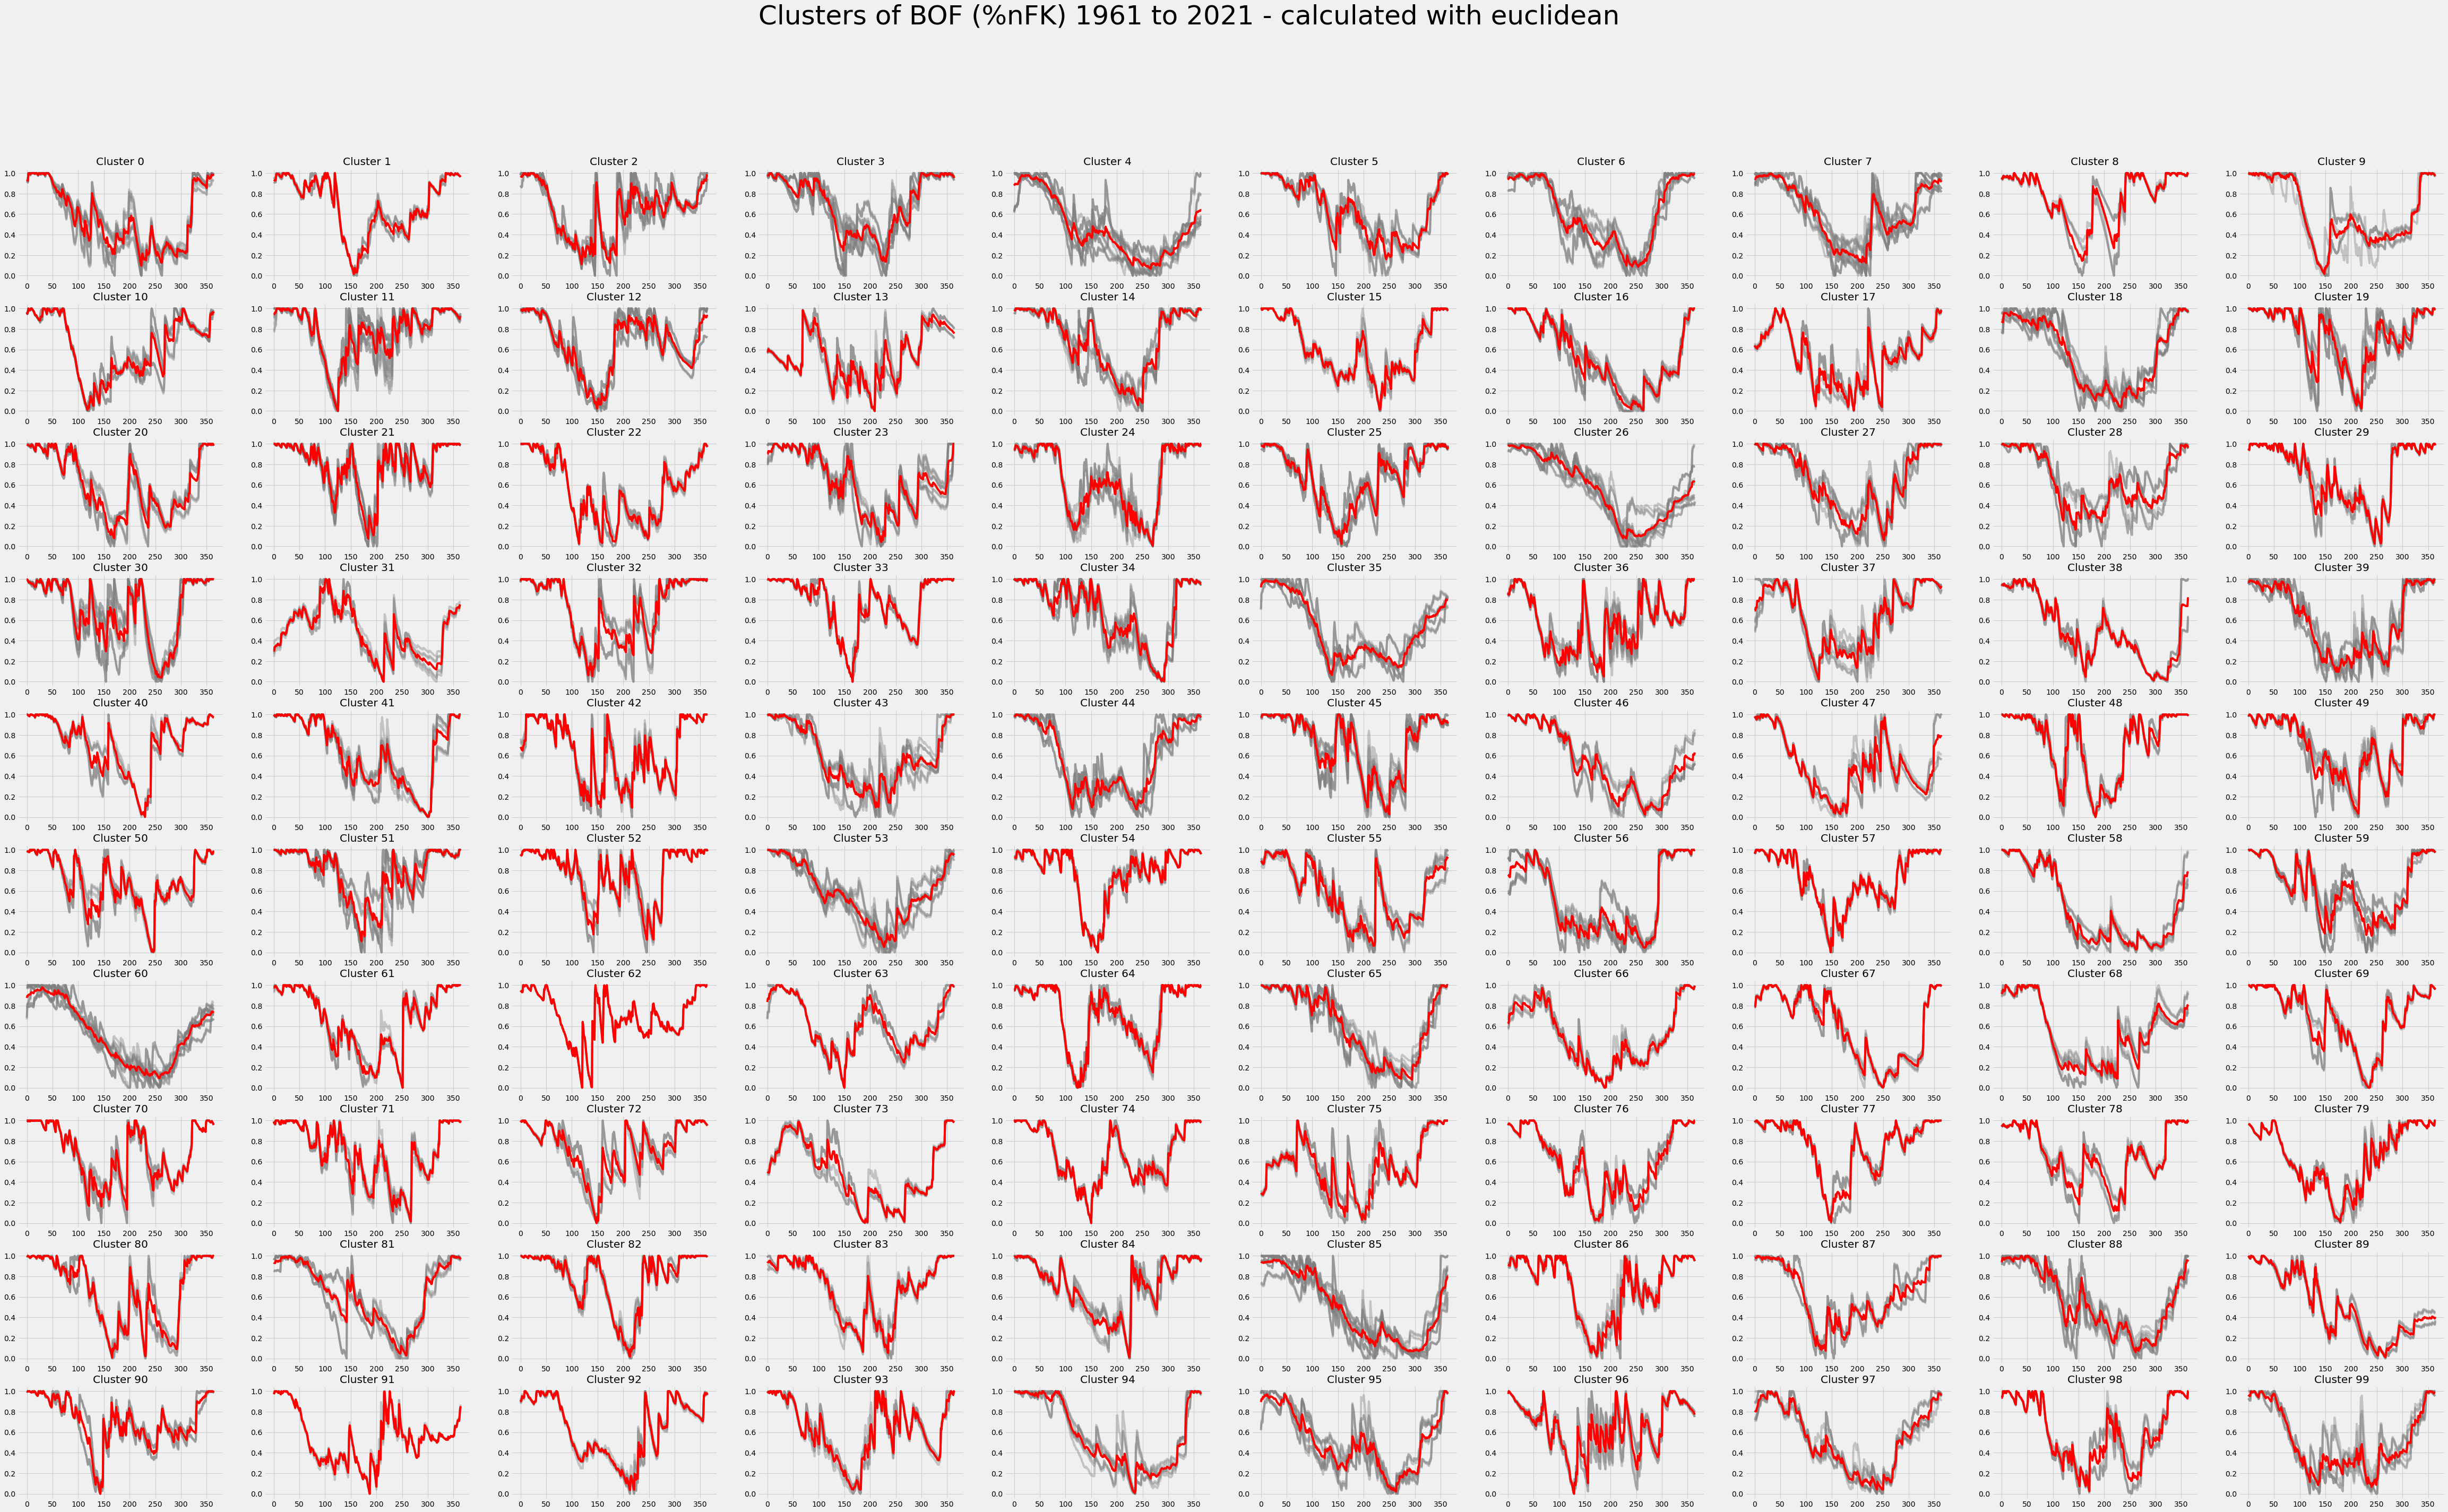

<Figure size 1872x1008 with 0 Axes>

In [14]:
### 10.) Plot result for k-Means euclidean -> relevant for classification
plot_count = 10

fig, axs = plt.subplots(nrows=plot_count, ncols=plot_count, figsize=(73,43), squeeze='false')
fig.suptitle("Clusters of BOF (%nFK) 1961 to 2021 - calculated with euclidean", fontsize=50)

row_i = 0
col_j = 0

for label in set(label_euc):
    cluster_euc = []
    for i, elem in enumerate(label_euc):
        if (km_euc.labels_[i] == label):
            axs[row_i, col_j].plot(df_list_norm[i], c="gray", alpha=0.4)
            cluster_euc.append(df_list_norm[i])
            
    if len(cluster_euc) > 0:
        axs[row_i, col_j].plot(np.average(np.vstack(cluster_euc), axis=0), c="red")
    
    axs[row_i, col_j].set_title("Cluster " + str(row_i*plot_count+col_j))
    col_j +=1
    
    if col_j%plot_count == 0:
        row_i +=1
        col_j = 0
        
plt.show()
plt.savefig('Cluster.png', dpi=500)

In [ ]:
### Optional: Get (tot) wss (withinss) of every k-means clustering iteration -> Working with 10er K steps -> better and compact visualization 
k_max = k_cluster
tot_wss = []


for k in range(1, 120, 10):
    km = TSKMeans(n_clusters=k, metric="euclidean", max_iter=1000, n_init=30).fit(df_norm)
    tot_wss.append(km.inertia_)

In [ ]:
### Optional: Plot (tot) withinss against number of k's 
clustering_k = [*range(1, 121, 10)]

wss = pd.DataFrame({'k_cluster': clustering_k, 'total withinss': tot_wss})

plt.xlabel("Number of k cluster")
plt.bar(wss.iloc[:, 0], wss.iloc[:, 1], label="withinss")
plt.legend()

plt.savefig('Cluster_plot_withinss.jpeg', dpi=100)

In [ ]:
# Cluster distribution for euclidean
cluster_c = [len(label_euc[label==i]) for i in range(k_cluster)]
cluster_n = [str(i) for i in range(k_cluster)]

plt.figure(figsize=(76,66))
plt.title("Cluster Distribution for K-Means")
plt.bar(cluster_n,cluster_c)
plt.show()